### Imports
Import the required libraries

In [1]:
# package(s) related to time, space and id
import logging
import datetime, time
import platform
import itertools
# you need these dependencies (you can get these from anaconda)
# package(s) related to the simulation
import simpy
import pandas as pd

# spatial libraries 
import pyproj
import shapely.geometry
from simplekml import Kml, Style

# package(s) for data handling
import numpy as np
import matplotlib.pyplot as plt

# OpenTNSim
import opentnsim

# Used for mathematical functions
import math             
import tqdm
# Used for making the graph to visualize our problem
import networkx as nx   

import plotly.express as px
from plotly.subplots import make_subplots

# logging.basicConfig(level=logging.DEBUG) #turn on all the debug messages
logging.basicConfig(level=logging.INFO)# turn off all the debug messages


### Create graph


In [2]:
# specify a number of coordinate along your route (coords are: lon, lat)
coords = [
    [0,0],
    [0.6475,0],
    [4.046285,0], 
    [4.495394,0],
    [5.394,0]
] 

# for each edge (between above coordinates) specify the depth (m)
depths = [6, 4.5, 3.2, 4.5]
current_speeds = [-0.5,-1.3,-2,-1.3]  # m/s
V_g_profile_up = [3,2.8,1.4,2.8]     # 9 ~ 11 km/h       600km for 65h
V_g_profile_down = [4.85,4.85,4,4.85]  # 17 km/h     600km for 35h
# check of nr of coords and nr of depths align
assert len(coords) == len(depths) + 1, 'nr of depths does not correspond to nr of coords'

In [3]:
# create a graph based on coords and depths
FG = nx.DiGraph()
nodes = []
path = []

# add nodes
Node = type('Site', (opentnsim.core.Identifiable, opentnsim.core.Locatable), {})

for index, coord in enumerate(coords):
    data_node = {"name": "Node " + str(index), "geometry": shapely.geometry.Point(coord[0], coord[1])}
    nodes.append(Node(**data_node))
    
positions = {}
for node in nodes:
    positions[node.name] = (node.geometry.x, node.geometry.y)
    FG.add_node(node.name, geometry = node.geometry)

# add edges
path = [[nodes[i], nodes[i+1]] for i in range(len(nodes)-1)]

for index, edge in enumerate(path):
    # For the energy consumption calculation we add info to the graph. We need depth info for resistance.
    # NB: the CalculateEnergy routine expects the graph to have "Info" that contains "GeneralDepth" 
    #     this may not be very generic!
    FG.add_edge(edge[0].name, edge[1].name, weight = 1, Info = {
        "GeneralDepth": depths[index],
        "CurrentSpeed": current_speeds[index],
        "VesselSpeedToGroundProfile_upstream": V_g_profile_up[index],
        "VesselSpeedToGroundProfile_downstream": V_g_profile_down[index]
    })

# toggle to undirected and back to directed to make sure all edges are two way traffic
FG = FG.to_undirected() 
FG = FG.to_directed() 

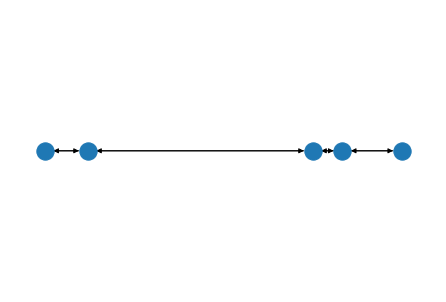

In [4]:
# show graph
nx.draw(FG, positions)
plt.show()

In [5]:
# This cell just shows that now a depth of 10 m is added to the edges. 
# You can use this to vary depths, e.g. make the middle edge shallower. Note that edges are bi-directional 
for edge in FG.edges:
    print('General depth for edge {} is {}'.format(edge, FG.get_edge_data(edge[0], edge[1])["Info"]["GeneralDepth"]))

General depth for edge ('Node 0', 'Node 1') is 6
General depth for edge ('Node 1', 'Node 0') is 6
General depth for edge ('Node 1', 'Node 2') is 4.5
General depth for edge ('Node 2', 'Node 1') is 4.5
General depth for edge ('Node 2', 'Node 3') is 3.2
General depth for edge ('Node 3', 'Node 2') is 3.2
General depth for edge ('Node 3', 'Node 4') is 4.5
General depth for edge ('Node 4', 'Node 3') is 4.5


### Create vessel - add VesselProperties and ConsumesEnergy mixins


In [6]:
# Make your preferred class out of available mix-ins.
TransportResource = type(
    "Vessel",
    (
        opentnsim.core.Identifiable,
        opentnsim.core.Movable,
        opentnsim.core.VesselProperties,  # needed to add vessel properties
        opentnsim.energy.ConsumesEnergy,
        opentnsim.core.ExtraMetadata,
    ),
    {},
)  # needed to calculate resistances

In [7]:
# Create a dict with all important settings

data_vessel_up = {
    "env": None,
    "name": 'Vessel M9',
    "route": None,
    "geometry": None,
    "v": None,  # m/s
    "V_g_ave":3,
    "use_V_g_profile":True,
    "type": None,
    "B": 11.4,
    "L": 135,
    "H_e": None, 
    "H_f": None, 
    "T": 2.65,
    "safety_margin": 0.3, # for tanker vessel with rocky bed the safety margin is recommended as 0.3 m
    "h_squat": False, # if consider the ship squatting while moving, set to True, otherwise set to False. Note that here we have disabled h_squat calculation since we regard the water depth h_0 is already reduced by squat effect. This applies to figures 3, 5, 7, 8 and 9.
    "payload":None,
    "vessel_type":"Dry_DH", #vessel types: "Container","Dry_SH","Dry_DH","Barge","Tanker". ("Dry_SH" means dry bulk single hull, "Dry_DH" means dry bulk double hull)    
    "P_installed": 1750.0,   
    "P_tot_given": None, # kW
    "P_tot_given_profile":False,
    "bulbous_bow": False, # if a vessel has no bulbous_bow, set to False; otherwise set to True.
    "sailing_on_power": False,
    "sailing_upstream":True,
    "wind_influence": False,
    "P_hotel_perc": 0,
    "P_hotel": None, # None: calculate P_hotel from percentage
    "x": 2,# number of propellers
    "L_w": 3.0 ,
    "C_B":0.87, 
    "C_year": 2000,
}             



In [8]:
# Create a dict with all important settings

data_vessel_down = {
    "env": None,
    "name": 'Vessel M9',
    "route": None,
    "geometry": None,
    "v": None,  # m/s
    "V_g_ave":4.44,
    "use_V_g_profile":True,
    "type": None,
    "B": 11.4,
    "L": 135,
    "H_e": None, 
    "H_f": None, 
    "T": 2.3,
    "safety_margin": 0.3, # for tanker vessel with rocky bed the safety margin is recommended as 0.3 m
    "h_squat": False, # if consider the ship squatting while moving, set to True, otherwise set to False. Note that here we have disabled h_squat calculation since we regard the water depth h_0 is already reduced by squat effect. This applies to figures 3, 5, 7, 8 and 9.
    "payload":None,
    "vessel_type":"Dry_DH", #vessel types: "Container","Dry_SH","Dry_DH","Barge","Tanker". ("Dry_SH" means dry bulk single hull, "Dry_DH" means dry bulk double hull)    
    "P_installed": 1750.0,   
    "P_tot_given": None, # kW
    "P_tot_given_profile":False,
    "bulbous_bow": False, # if a vessel has no bulbous_bow, set to False; otherwise set to True.
    "sailing_on_power": False,
    "sailing_upstream":False,
    "wind_influence": False,
    "P_hotel_perc": 0,
    "P_hotel": None, # None: calculate P_hotel from percentage
    "x": 2,# number of propellers
    "L_w": 3.0 ,
    "C_B":0.87, 
    "C_year": 2000, # although the construction year of Herso 1 is 1961, checking with the SFC used in the paper,it is similar as year of 2000
}             



### Define paths
We are going to create a simulation in which a vessel moves from *Node 1* to *Node 4*. Therefore, we need to create a vessel to which we will need to append this paths. Therefore, first let's create the path.

In [9]:
path_upstream = nx.dijkstra_path(FG, nodes[0].name, nodes[4].name)
path_downstream = nx.dijkstra_path(FG, nodes[4].name, nodes[0].name)

### Run simulation


In [10]:
def run_simulation(path,**data_vessel):
    
    # Start simpy environment
    simulation_start = datetime.datetime.now()
    env = simpy.Environment(initial_time = time.mktime(simulation_start.timetuple()))
    env.epoch = time.mktime(simulation_start.timetuple())

    # Add graph to environment
    env.FG = FG

    # Add environment and path to the vessel
    # create a fresh instance of vessel
    vessel = TransportResource(**data_vessel)
    vessel.env = env                                        #the created environment
    vessel.name = 'Vessel M9'                     
    vessel.route = path                                     #the route (the sequence of nodes, as stored as the second column in the path)
    vessel.geometry = env.FG.nodes[path[0]]['geometry']     #a shapely.geometry.Point(lon,lat) (here taken as the starting node of the vessel)

    env.process(vessel.move())
    env.run()
    
    return vessel

In [11]:
vessel_upstream = run_simulation(path = path_upstream, **data_vessel_up)
# create an EnergyCalculation object and perform energy consumption calculation
energycalculation_upstream = opentnsim.energy.EnergyCalculation(FG, vessel_upstream)
energycalculation_upstream.calculate_energy_consumption()

# create dataframe from energy calculation computation
df_upstream = pd.DataFrame.from_dict(energycalculation_upstream.energy_use)
selected = ['edge_start','edge_stop','distance','P_tot','P_installed','total_energy','total_diesel_consumption_C_year_ICE_mass','total_diesel_consumption_ICE_vol',
            'total_emission_CO2','total_emission_PM10','total_emission_NOX',
            'total_LH2_consumption_PEMFC_mass','total_LH2_consumption_SOFC_mass','total_LH2_consumption_PEMFC_vol','total_LH2_consumption_SOFC_vol',
           'total_eLNG_consumption_PEMFC_mass','total_eLNG_consumption_SOFC_mass','total_eLNG_consumption_PEMFC_vol','total_eLNG_consumption_SOFC_vol',
            'total_eLNG_consumption_ICE_mass','total_eLNG_consumption_ICE_vol',
            'total_eMethanol_consumption_PEMFC_mass','total_eMethanol_consumption_SOFC_mass','total_eMethanol_consumption_PEMFC_vol','total_eMethanol_consumption_SOFC_vol',
            'total_eMethanol_consumption_ICE_mass','total_eMethanol_consumption_ICE_vol','total_eNH3_consumption_PEMFC_mass','total_eNH3_consumption_SOFC_mass',
            'total_eNH3_consumption_PEMFC_vol','total_eNH3_consumption_SOFC_vol','total_eNH3_consumption_ICE_mass','total_eNH3_consumption_ICE_vol',
            'total_Li_NMC_Battery_mass','total_Li_NMC_Battery_vol','total_Battery2000kWh_consumption_num']
df_upstream = df_upstream[selected]
df_upstream

3.5 V_w
238.9895399982425 SFC final
4.1 V_w
218.31903739107412 SFC final
3.4 V_w
230.69357912521932 SFC final
4.1 V_w
218.31903739107412 SFC final


C:\ANACONDA2021\envs\sim\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.



,edge_start,edge_stop,distance,P_tot,P_installed,total_energy,total_diesel_consumption_C_year_ICE_mass,total_diesel_consumption_ICE_vol,total_emission_CO2,total_emission_PM10,...,total_eMethanol_consumption_ICE_vol,total_eNH3_consumption_PEMFC_mass,total_eNH3_consumption_SOFC_mass,total_eNH3_consumption_PEMFC_vol,total_eNH3_consumption_SOFC_vol,total_eNH3_consumption_ICE_mass,total_eNH3_consumption_ICE_vol,total_Li_NMC_Battery_mass,total_Li_NMC_Battery_vol,total_Battery2000kWh_consumption_num
0,POINT (0 0),POINT (0.6475 0),72079.370289,303.908984,1750.0,2028.293350,4.847409e+05,0.625765,1.536983e+06,765.768817,...,1.436096,8.820584e+05,9.349819e+05,1.435909,1.522064,1.217731e+06,1.982353,2.304879e+07,18.240048,1.267683
1,POINT (0.6475 0),POINT (4.046285 0),378351.015516,722.002251,1750.0,27100.226666,5.916495e+06,7.637759,1.875962e+07,8333.083230,...,17.528243,1.261024e+07,1.225668e+07,20.528295,19.952735,1.486299e+07,24.195564,3.079571e+08,243.707074,16.937642
2,POINT (4.046285 0),POINT (4.495394 0),49994.585191,457.911421,1750.0,4542.280070,1.047875e+06,1.352729,3.322530e+06,1513.490987,...,3.104440,1.989158e+06,2.066206e+06,3.238164,3.363592,2.632395e+06,4.285294,5.161682e+07,40.847842,2.838925
3,POINT (4.495394 0),POINT (5.394 0),100032.362344,722.002251,1750.0,7165.038766,1.564264e+06,2.019350,4.959863e+06,2203.186900,...,4.634299,3.334025e+06,3.240548e+06,5.427483,5.275311,3.929631e+06,6.397074,8.142090e+07,64.433802,4.478149


In [12]:
upstream_total_diesel_use = (df_upstream['total_diesel_consumption_C_year_ICE_mass']/1000).sum() #kg
upstream_total_diesel_use_liters = upstream_total_diesel_use * 1.16279 # liters
upstream_total_diesel_use_liters

10480.662905160503

In [13]:
(upstream_total_diesel_use_liters-11457)/11457 # difference compared with the results from fuel report

-0.08521751722436037

In [14]:
plot_data_up = pd.DataFrame()
plot_data_up['diesel kg/km']= (df_upstream['total_diesel_consumption_C_year_ICE_mass']/1000)/ (df_upstream['distance']/1000)
plot_data_up['CO2 g/km'] = (df_upstream['total_emission_CO2'])/ (df_upstream['distance']/1000)
plot_data_up['PM10 g/km'] = (df_upstream['total_emission_PM10'])/ (df_upstream['distance']/1000)
plot_data_up['NOx g/km'] = (df_upstream['total_emission_NOX'])/ (df_upstream['distance']/1000)

plot_data_up

,diesel kg/km,CO2 g/km,PM10 g/km,NOx g/km
0,6.725099,21323.484350,10.623967,300.718064
1,15.637583,49582.580165,22.024741,685.068634
2,20.959767,66457.797161,30.273098,901.299110
3,15.637583,49582.580165,22.024741,685.068634


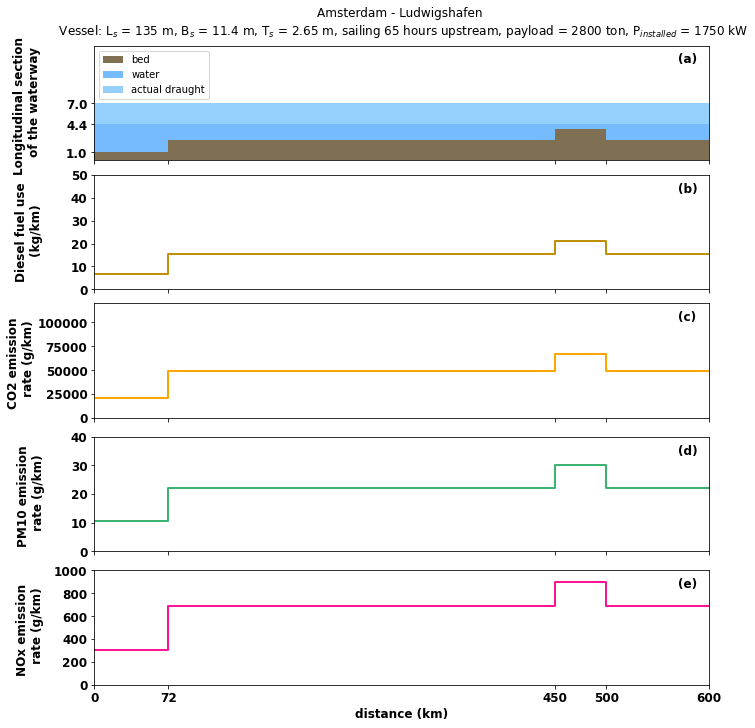

In [15]:
fig, axs = plt.subplots(5, 1, figsize=(10, 10), sharex=True,constrained_layout=True)
fontsize=12

ax=plt.subplot(511)    # Longitudinal section of the waterway

plt.title('Amsterdam - Ludwigshafen \n Vessel: L$_s$ = 135 m, B$_s$ = 11.4 m, T$_s$ = 2.65 m, sailing 65 hours upstream, payload = 2800 ton, P$_{installed}$ = 1750 kW',y=1.05)

dist=[0,72,72,450,450,500,500,600]
water_level=[3.4,3.4,1.9,1.9,0.6,0.6,1.9,1.9]
bed_level=[1,1,2.5,2.5,3.8,3.8,2.5,2.5]
draft=[2.65,2.65,2.65,2.65,2.65,2.65,2.65,2.65]

plt.stackplot(dist,bed_level,water_level,draft, labels=['bed','water','actual draught'],colors=['#7f7053','#75bbfd','#95d0fc'])
plt.ylabel('Longitudinal section \n of the waterway',fontsize=12,fontweight='bold',labelpad=25)
plt.xlim(0, 600)
plt.ylim(0, 14)
plt.xticks( weight = 'bold')
plt.yticks([1,4.4,7], weight = 'bold', fontsize=12)
ax.legend(loc='upper left')
ax.text(600*0.95, 12, '(a)', fontsize=12,weight = 'bold')

ax=plt.subplot(512)    #  fuel (diesel) consumption kg/km 


diesel_fp1= np.expand_dims(plot_data_up['diesel kg/km'],0).repeat(2,axis=1)
diesel_fp1=diesel_fp1[0].tolist()
plt.plot(dist, diesel_fp1,color='#bf9005',linewidth='2')


plt.ylabel('Diesel fuel use\n (kg/km)',fontsize=12,fontweight='bold',labelpad=28)
plt.ylim(0, 50)
plt.xlim(0, 600)
plt.xticks( weight = 'bold')
plt.yticks( weight = 'bold', fontsize=12)
# ax.legend(loc='upper left')
ax.text(600*0.95, 50*11/13, '(b)', fontsize=12,weight = 'bold')

ax=plt.subplot(513)    #  CO2 emission rates g/km

EMrCO2_fp2= np.expand_dims(plot_data_up['CO2 g/km'],0).repeat(2,axis=1)
EMrCO2_fp2=EMrCO2_fp2[0].tolist()

plt.plot(dist, EMrCO2_fp2,color='orange',linewidth='2')


# ax.legend(loc='upper left')
plt.ylabel('CO2 emission \n rate (g/km)',fontsize=12,fontweight='bold',labelpad=2)
plt.ylim(0,120000)
plt.xlim(0, 600)
plt.xticks( weight = 'bold')
plt.yticks( weight = 'bold', fontsize=12)
ax.text(600*0.95, 120000*11/13, '(c)', fontsize=12,weight = 'bold')

ax=plt.subplot(514)    #  PM10 emission rates g/km

EMrPM10_fp2= np.expand_dims(plot_data_up['PM10 g/km'],0).repeat(2,axis=1)
EMrPM10_fp2=EMrPM10_fp2[0].tolist()

plt.plot(dist, EMrPM10_fp2,color='mediumseagreen',linewidth='2')



# ax.legend(loc='upper left')
plt.ylabel('PM10 emission \n rate (g/km)',fontsize=12,fontweight='bold',labelpad=26)
plt.ylim(0, 40)
plt.xlim(0, 600)
plt.xticks( weight = 'bold')
plt.yticks( weight = 'bold', fontsize=12)
ax.text(600*0.95, 40*11/13, '(d)', fontsize=12,weight = 'bold')

ax=plt.subplot(515)     #  NOx emission rates g/km



EMrNOx_fp2= np.expand_dims(plot_data_up['NOx g/km'],0).repeat(2,axis=1)
EMrNOx_fp2=EMrNOx_fp2[0].tolist()

plt.plot(dist, EMrNOx_fp2,color='deeppink',linewidth='2')



plt.ylabel('NOx emission \n rate (g/km)',fontsize=12,fontweight='bold',labelpad=10)
plt.xlabel('distance (km)',fontsize=12,fontweight='bold',labelpad=3)
plt.ylim(0, 1000)
plt.xlim(0, 600)
# ax.legend(loc='upper left')
plt.xticks([0,72,450,500,600], weight = 'bold', fontsize=12)
plt.yticks( weight = 'bold', fontsize=12)
ax.text(600*0.95, 1000*11/13, '(e)', fontsize=12,weight = 'bold')

plt.savefig('validation_upstream_Amsterdam_Ludwigshafen_MVS135.pdf',bbox_inches = 'tight', dpi=600, format='pdf')  

In [16]:
vessel_downstream = run_simulation(path = path_downstream, **data_vessel_down)
# create an EnergyCalculation object and perform energy consumption calculation
energycalculation_downstream = opentnsim.energy.EnergyCalculation(FG, vessel_downstream)
energycalculation_downstream.calculate_energy_consumption()

# create dataframe from energy calculation computation
df_downstream = pd.DataFrame.from_dict(energycalculation_downstream.energy_use)
selected = ['edge_start','edge_stop','distance','P_tot','P_installed','total_energy','total_diesel_consumption_C_year_ICE_mass','total_diesel_consumption_ICE_vol',
            'total_emission_CO2','total_emission_PM10','total_emission_NOX',
            'total_LH2_consumption_PEMFC_mass','total_LH2_consumption_SOFC_mass','total_LH2_consumption_PEMFC_vol','total_LH2_consumption_SOFC_vol',
           'total_eLNG_consumption_PEMFC_mass','total_eLNG_consumption_SOFC_mass','total_eLNG_consumption_PEMFC_vol','total_eLNG_consumption_SOFC_vol',
            'total_eLNG_consumption_ICE_mass','total_eLNG_consumption_ICE_vol',
            'total_eMethanol_consumption_PEMFC_mass','total_eMethanol_consumption_SOFC_mass','total_eMethanol_consumption_PEMFC_vol','total_eMethanol_consumption_SOFC_vol',
            'total_eMethanol_consumption_ICE_mass','total_eMethanol_consumption_ICE_vol','total_eNH3_consumption_PEMFC_mass','total_eNH3_consumption_SOFC_mass',
            'total_eNH3_consumption_PEMFC_vol','total_eNH3_consumption_SOFC_vol','total_eNH3_consumption_ICE_mass','total_eNH3_consumption_ICE_vol',
            'total_Li_NMC_Battery_mass','total_Li_NMC_Battery_vol','total_Battery2000kWh_consumption_num']
df_downstream = df_downstream[selected]
df_downstream

3.55 V_w
235.72021945425692 SFC final
2 V_w
256.25 SFC final
3.55 V_w
235.72021945425692 SFC final
4.35 V_w
222.0463941628589 SFC final


C:\ANACONDA2021\envs\sim\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.



,edge_start,edge_stop,distance,P_tot,P_installed,total_energy,total_diesel_consumption_C_year_ICE_mass,total_diesel_consumption_ICE_vol,total_emission_CO2,total_emission_PM10,...,total_eMethanol_consumption_ICE_vol,total_eNH3_consumption_PEMFC_mass,total_eNH3_consumption_SOFC_mass,total_eNH3_consumption_PEMFC_vol,total_eNH3_consumption_SOFC_vol,total_eNH3_consumption_ICE_mass,total_eNH3_consumption_ICE_vol,total_Li_NMC_Battery_mass,total_Li_NMC_Battery_vol,total_Battery2000kWh_consumption_num
0,POINT (5.394 0),POINT (4.495394 0),100032.362344,350.635560,1750.0,2008.871903,4.735317e+05,0.611295,1.501442e+06,716.860847,...,1.402888,8.736125e+05,9.260292e+05,1.422160,1.507489,1.189572e+06,1.936513,2.282809e+07,18.065395,1.255545
1,POINT (4.495394 0),POINT (4.046285 0),49994.585191,75.571132,1750.0,262.371347,6.723266e+04,0.086792,2.131767e+05,192.055826,...,0.199184,1.905458e+05,1.631620e+05,0.310191,0.265613,1.688970e+05,0.274949,2.981493e+06,2.359455,0.163982
2,POINT (4.046285 0),POINT (0.6475 0),378351.015516,350.635560,1750.0,7598.128314,1.791032e+06,2.312091,5.678883e+06,2711.372831,...,5.306123,3.304252e+06,3.502508e+06,5.379015,5.701756,4.499302e+06,7.324444,8.634237e+07,68.328492,4.748830
3,POINT (0.6475 0),POINT (0 0),72079.370289,642.455003,1750.0,2652.219475,5.889158e+05,0.760247,1.867294e+06,830.001324,...,1.744725,1.203786e+06,1.169184e+06,1.959651,1.903323,1.479431e+06,2.408377,3.013886e+07,23.850895,1.657637


In [17]:
downstream_total_diesel_use = (df_downstream['total_diesel_consumption_C_year_ICE_mass']/1000).sum() #kg
downstream_total_diesel_use_liters = downstream_total_diesel_use * 1.16279 # liters
downstream_total_diesel_use_liters

3396.175436707191

In [18]:
(downstream_total_diesel_use_liters-3488)/3488 # difference compared with the results from fuel report

-0.02632584956789255

In [19]:
plot_data_down = pd.DataFrame()
plot_data_down['diesel kg/km']= (df_downstream['total_diesel_consumption_C_year_ICE_mass']/1000)/ (df_downstream['distance']/1000)
plot_data_down['CO2 g/km'] = (df_downstream['total_emission_CO2'])/ (df_downstream['distance']/1000)
plot_data_down['PM10 g/km'] = (df_downstream['total_emission_PM10'])/ (df_downstream['distance']/1000)
plot_data_down['NOx g/km'] = (df_downstream['total_emission_NOX'])/ (df_downstream['distance']/1000)


In [20]:
plot_data_down=plot_data_down[::-1]
plot_data_down

,diesel kg/km,CO2 g/km,PM10 g/km,NOx g/km
3,8.170379,25906.079647,11.515102,355.073023
2,4.733785,15009.563131,7.166289,207.595308
1,1.344799,4263.996158,3.841533,90.276015
0,4.733785,15009.563131,7.166289,207.595308


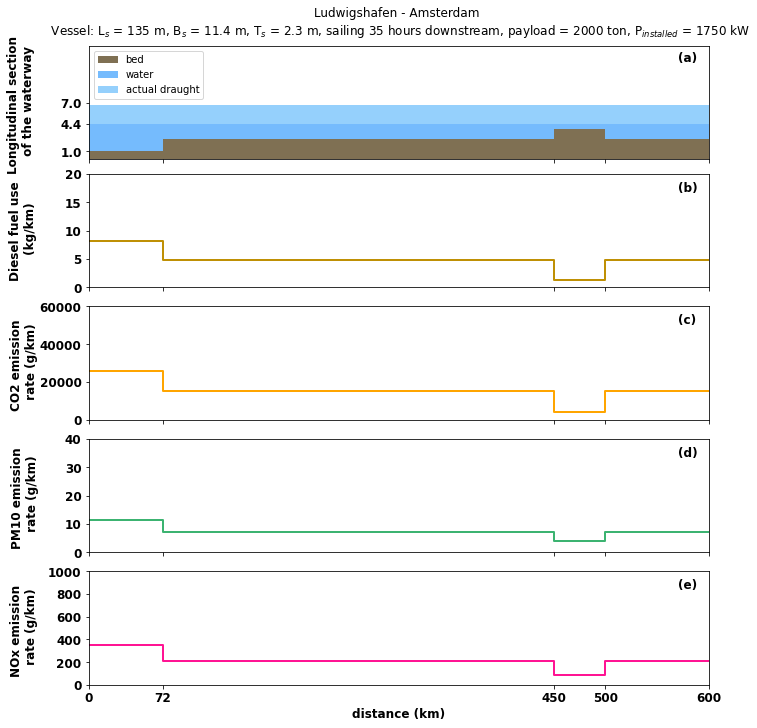

In [21]:
fig, axs = plt.subplots(5, 1, figsize=(10, 10), sharex=True,constrained_layout=True)
fontsize=12

ax=plt.subplot(511)    # Longitudinal section of the waterway

plt.title('Ludwigshafen - Amsterdam \n Vessel: L$_s$ = 135 m, B$_s$ = 11.4 m, T$_s$ = 2.3 m, sailing 35 hours downstream, payload = 2000 ton, P$_{installed}$ = 1750 kW',y=1.05)

dist=[0,72,72,450,450,500,500,600]
water_level=[3.4,3.4,1.9,1.9,0.6,0.6,1.9,1.9]
bed_level=[1,1,2.5,2.5,3.8,3.8,2.5,2.5]
draft=[2.3,2.3,2.3,2.3,2.3,2.3,2.3,2.3]

plt.stackplot(dist,bed_level,water_level,draft, labels=['bed','water','actual draught'],colors=['#7f7053','#75bbfd','#95d0fc'])
plt.ylabel('Longitudinal section \n of the waterway',fontsize=12,fontweight='bold',labelpad=25)
plt.xlim(0, 600)
plt.ylim(0, 14)
plt.xticks( weight = 'bold')
plt.yticks([1,4.4,7], weight = 'bold', fontsize=12)
ax.legend(loc='upper left')
ax.text(600*0.95, 12, '(a)', fontsize=12,weight = 'bold')

ax=plt.subplot(512)    #  fuel (diesel) consumption kg/km 


diesel_fp1= np.expand_dims(plot_data_down['diesel kg/km'],0).repeat(2,axis=1)
diesel_fp1=diesel_fp1[0].tolist()

plt.plot(dist, diesel_fp1,color='#bf9005',linewidth='2')


plt.ylabel('Diesel fuel use\n (kg/km)',fontsize=12,fontweight='bold',labelpad=28)
plt.ylim(0, 20)
plt.xlim(0, 600)
plt.xticks( weight = 'bold')
plt.yticks( weight = 'bold', fontsize=12)
# ax.legend(loc='upper left')
ax.text(600*0.95, 20*11/13, '(b)', fontsize=12,weight = 'bold')

ax=plt.subplot(513)    #  CO2 emission rates g/km

EMrCO2_fp2= np.expand_dims(plot_data_down['CO2 g/km'],0).repeat(2,axis=1)
EMrCO2_fp2=EMrCO2_fp2[0].tolist()

plt.plot(dist, EMrCO2_fp2,color='orange',linewidth='2')


# ax.legend(loc='upper left')
plt.ylabel('CO2 emission \n rate (g/km)',fontsize=12,fontweight='bold',labelpad=2)
plt.ylim(0, 60000)
plt.xlim(0, 600)
plt.xticks( weight = 'bold')
plt.yticks( weight = 'bold', fontsize=12)
ax.text(600*0.95, 60000*11/13, '(c)', fontsize=12,weight = 'bold')

ax=plt.subplot(514)    #  PM10 emission rates g/km

EMrPM10_fp2= np.expand_dims(plot_data_down['PM10 g/km'],0).repeat(2,axis=1)
EMrPM10_fp2=EMrPM10_fp2[0].tolist()

plt.plot(dist, EMrPM10_fp2,color='mediumseagreen',linewidth='2')



# ax.legend(loc='upper left')
plt.ylabel('PM10 emission \n rate (g/km)',fontsize=12,fontweight='bold',labelpad=26)
plt.ylim(0, 40)
plt.xlim(0, 600)
plt.xticks( weight = 'bold')
plt.yticks( weight = 'bold', fontsize=12)
ax.text(600*0.95, 40*11/13, '(d)', fontsize=12,weight = 'bold')

ax=plt.subplot(515)     #  NOx emission rates g/km



EMrNOx_fp2= np.expand_dims(plot_data_down['NOx g/km'],0).repeat(2,axis=1)
EMrNOx_fp2=EMrNOx_fp2[0].tolist()

plt.plot(dist, EMrNOx_fp2,color='deeppink',linewidth='2')



plt.ylabel('NOx emission \n rate (g/km)',fontsize=12,fontweight='bold',labelpad=10)
plt.xlabel('distance (km)',fontsize=12,fontweight='bold',labelpad=3)
plt.ylim(0, 1000)
plt.xlim(0, 600)
# ax.legend(loc='upper left')
plt.xticks([0,72,450,500,600], weight = 'bold', fontsize=12)
plt.yticks( weight = 'bold', fontsize=12)
ax.text(600*0.95, 1000*11/13, '(e)', fontsize=12,weight = 'bold')

plt.savefig('validation_downstream_Ludwigshafen_Amsterdam_MVS135.pdf',bbox_inches = 'tight', dpi=600, format='pdf')  

In [22]:
roundtrip_total_diesel_use_liters = upstream_total_diesel_use_liters + downstream_total_diesel_use_liters
roundtrip_total_diesel_use_liters

13876.838341867693

In [23]:
(roundtrip_total_diesel_use_liters - 14945) / 14945

-0.071472844304604